
QFT circuit for n=2


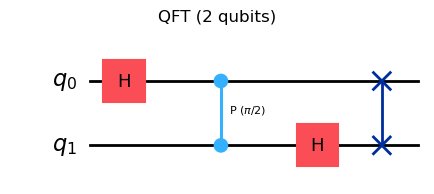

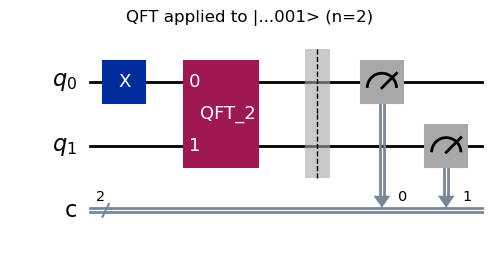

Counts (n=2): {'11': 492, '01': 513, '10': 482, '00': 561}


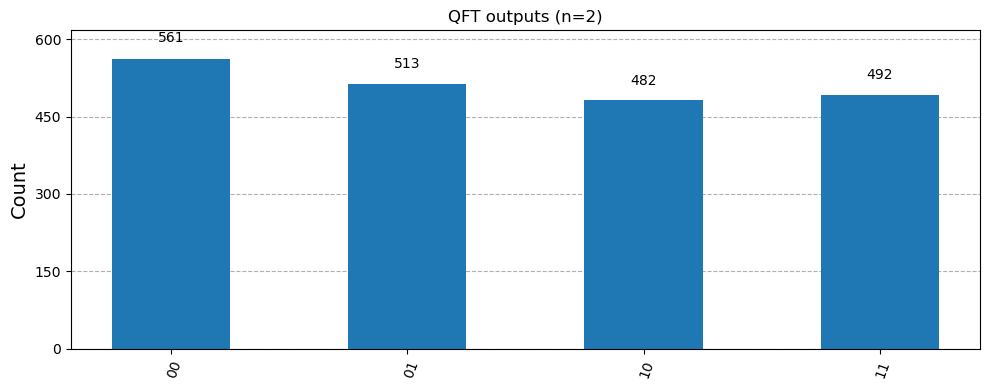


QFT circuit for n=3


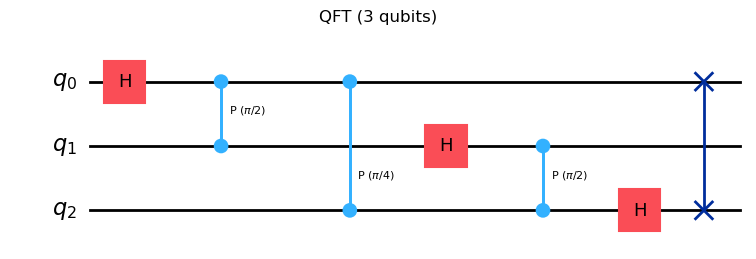

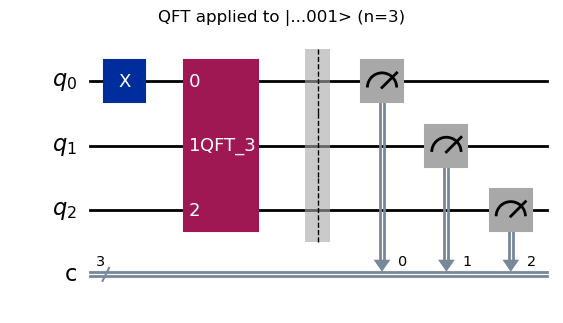

Counts (n=3): {'101': 257, '110': 249, '000': 257, '001': 243, '100': 266, '111': 262, '011': 264, '010': 250}


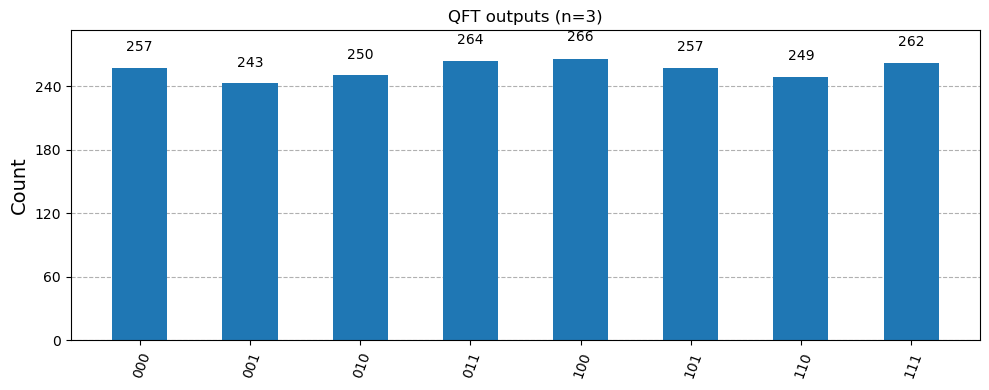


QFT circuit for n=4


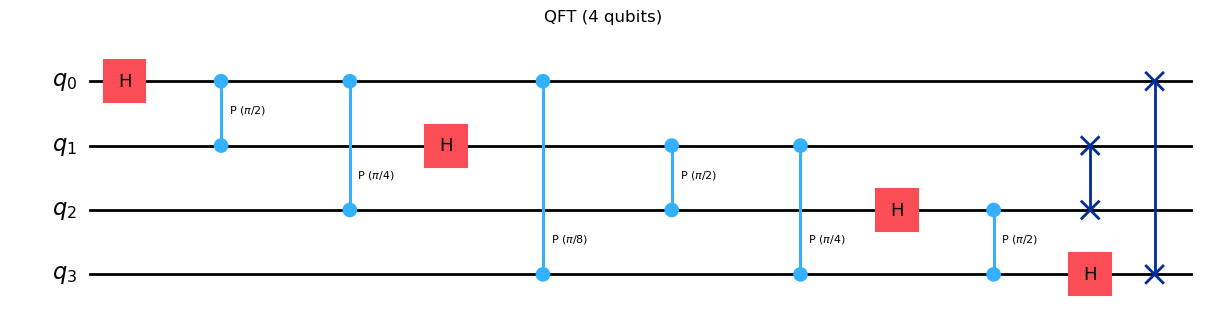

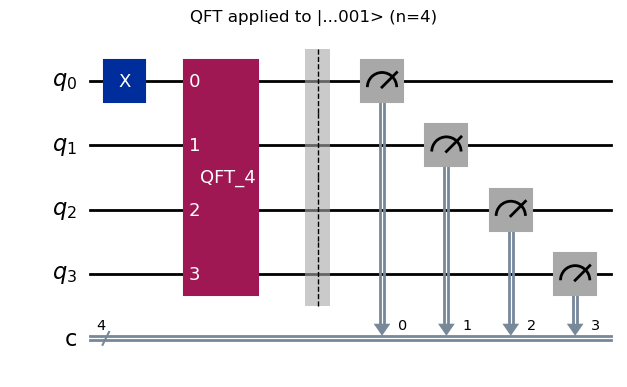

Counts (n=4): {'0110': 121, '1111': 127, '0101': 119, '0111': 116, '1101': 120, '0100': 153, '1000': 130, '1001': 118, '1010': 124, '1011': 129, '0010': 122, '1110': 123, '0001': 141, '0011': 126, '0000': 132, '1100': 147}


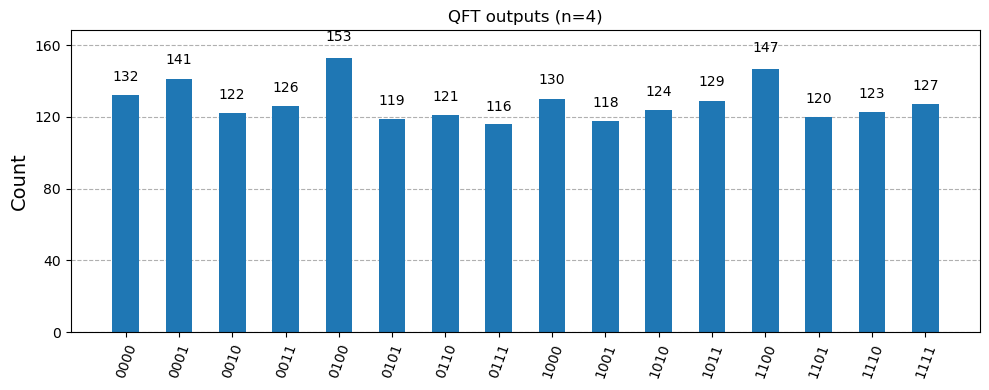

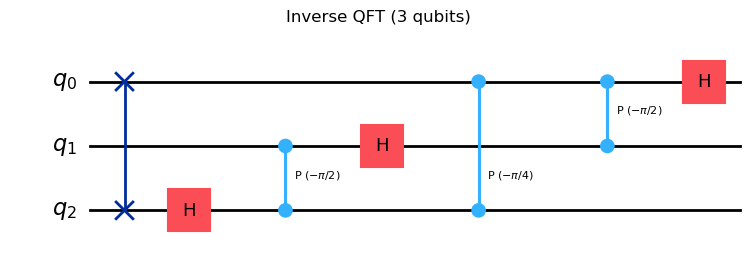

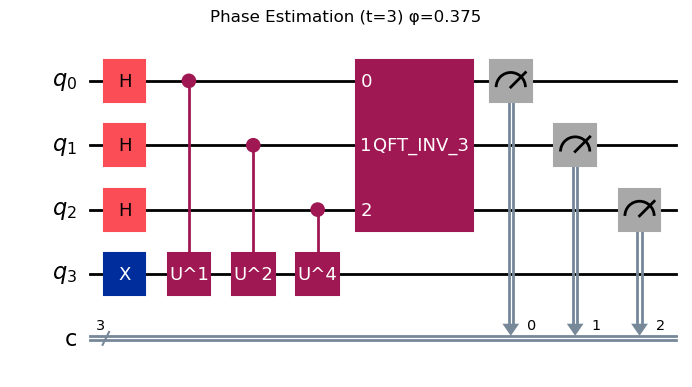

Phase estimation counts: {'110': 2990, '111': 515, '001': 296, '010': 141, '011': 154}


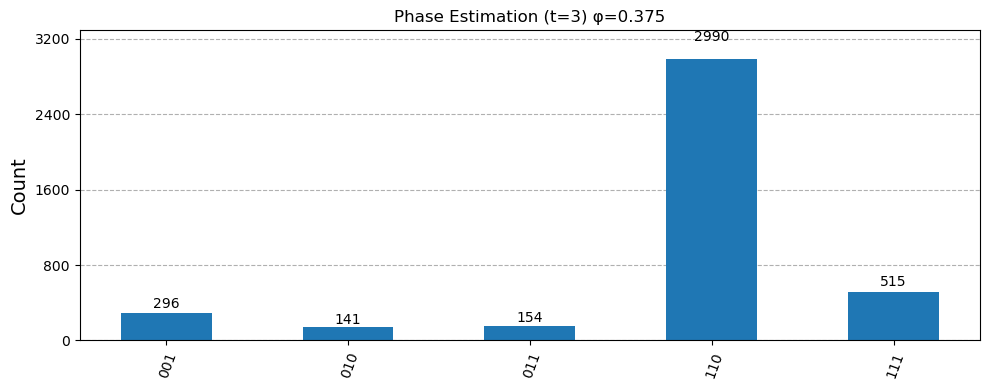

In [14]:
# ==============================================================
# Quantum Fourier Transform (QFT), Inverse QFT, and Phase Estimation
# Fully working under all modern Qiskit versions, with visible plots
# ==============================================================

%matplotlib inline
import numpy as np
from math import pi
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)

# --- Qiskit imports ---
from qiskit import QuantumCircuit, transpile
try:
    from qiskit_aer import AerSimulator
except ImportError:
    from qiskit.providers.aer import AerSimulator

from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate


# ==============================================================
# Utility: Run circuit and return measurement counts
# ==============================================================
def run_counts(qc, shots=2048):
    backend = AerSimulator()
    t_qc = transpile(qc, backend)
    result = backend.run(t_qc, shots=shots).result()
    return result.get_counts()


# ==============================================================
# Build QFT and inverse QFT
# ==============================================================
def build_qft(n):
    qc = QuantumCircuit(n, name=f"QFT_{n}")
    for j in range(n):
        qc.h(j)
        for k in range(2, n - j + 1):
            angle = pi / (2 ** (k - 1))
            control = j + k - 1
            target = j
            qc.cp(angle, control, target)
    for i in range(n // 2):
        qc.swap(i, n - 1 - i)
    return qc


def build_inverse_qft(n):
    iqft = build_qft(n).inverse()
    iqft.name = f"QFT_INV_{n}"
    return iqft


# ==============================================================
# Demonstrate QFT and measure
# ==============================================================
def demo_qfts_and_measure(n_list=[2, 3, 4], shots=2048):
    for n in n_list:
        qft_qc = build_qft(n)
        print(f"\nQFT circuit for n={n}")
        qft_qc.draw('mpl', fold=200)
        plt.title(f"QFT ({n} qubits)")
        plt.show()

        qc = QuantumCircuit(n, n)
        qc.x(0)
        qc.append(qft_qc.to_gate(), range(n))
        qc.barrier()
        qc.measure(range(n), range(n))
        qc.draw('mpl', fold=200)
        plt.title(f"QFT applied to |...001> (n={n})")
        plt.show()

        counts = run_counts(qc, shots)
        print(f"Counts (n={n}):", counts)
        plot_histogram(counts, title=f"QFT outputs (n={n})")
        plt.show()


# ==============================================================
# Inverse QFT visualization
# ==============================================================
def demo_inverse_qft(n=3):
    inv = build_inverse_qft(n)
    inv.draw('mpl', fold=200)
    plt.title(f"Inverse QFT ({n} qubits)")
    plt.show()


# ==============================================================
# Phase Estimation
# ==============================================================
def phase_unitary(phi):
    """Return single-qubit unitary with eigenvalue e^{2πiφ} on |1>."""
    return np.array([[1, 0], [0, np.exp(2j * pi * phi)]])


def build_phase_estimation(count_qubits=3, phi=3/8):
    """Build phase estimation circuit."""
    total = count_qubits + 1
    qc = QuantumCircuit(total, count_qubits)

    # Initialize target in |1>
    qc.x(total - 1)

    # Apply Hadamard gates to counting qubits
    qc.h(range(count_qubits))

    # Controlled-U^(2^j)
    for j in range(count_qubits):
        power = 2 ** j
        U_power = np.linalg.matrix_power(phase_unitary(phi), power)
        U_gate = UnitaryGate(U_power, label=f"U^{power}")
        controlled_U = U_gate.control(1)
        qc.append(controlled_U, [j, total - 1])

    # Apply inverse QFT to counting register
    iqft = build_inverse_qft(count_qubits)
    qc.append(iqft.to_gate(), range(count_qubits))

    # Measure
    qc.measure(range(count_qubits), range(count_qubits))
    return qc


def demo_phase_estimation(count_qubits=3, phi=3/8, shots=4096):
    pe_qc = build_phase_estimation(count_qubits, phi)
    pe_qc.draw('mpl', fold=200)
    plt.title(f"Phase Estimation (t={count_qubits}) φ={phi}")
    plt.show()

    counts = run_counts(pe_qc, shots)
    print("Phase estimation counts:", counts)
    plot_histogram(counts, title=f"Phase Estimation (t={count_qubits}) φ={phi}")
    plt.show()


# ==============================================================
# Run all demos
# ==============================================================
if __name__ == "__main__":
    SHOT_QFT = 2048
    SHOT_PE = 4096

    demo_qfts_and_measure([2, 3, 4], SHOT_QFT)
    demo_inverse_qft(3)
    demo_phase_estimation(3, 3/8, SHOT_PE)
